In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler



import warnings
warnings.filterwarnings("ignore")


# Data Collection and Exploration

In [33]:
# Load dataset
df = pd.read_csv("hotel_bookings.csv")

# Check the structure
print(df.shape)
print(df.columns)
df.head()

(119390, 32)
Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [34]:
if df['arrival_date_month'].dtype == 'object':
    # Convert full month name (e.g., "July") to number (e.g., 7)
    df['arrival_date_month'] = pd.to_datetime(df['arrival_date_month'], format='%B').dt.month

# Create a datetime column using year, month, day
df['arrival_date'] = pd.to_datetime(dict(
    year=df['arrival_date_year'],
    month=df['arrival_date_month'],
    day=df['arrival_date_day_of_month']
))

# Group by date to count number of bookings per day
daily_bookings = df.groupby('arrival_date').size().reset_index(name='total_bookings')

# Set index to datetime for time series analysis
daily_bookings.set_index('arrival_date', inplace=True)

# Preview the result
print(daily_bookings.head())

              total_bookings
arrival_date                
2015-07-01               122
2015-07-02                93
2015-07-03                56
2015-07-04                88
2015-07-05                53


## Visualizing the Time-Series

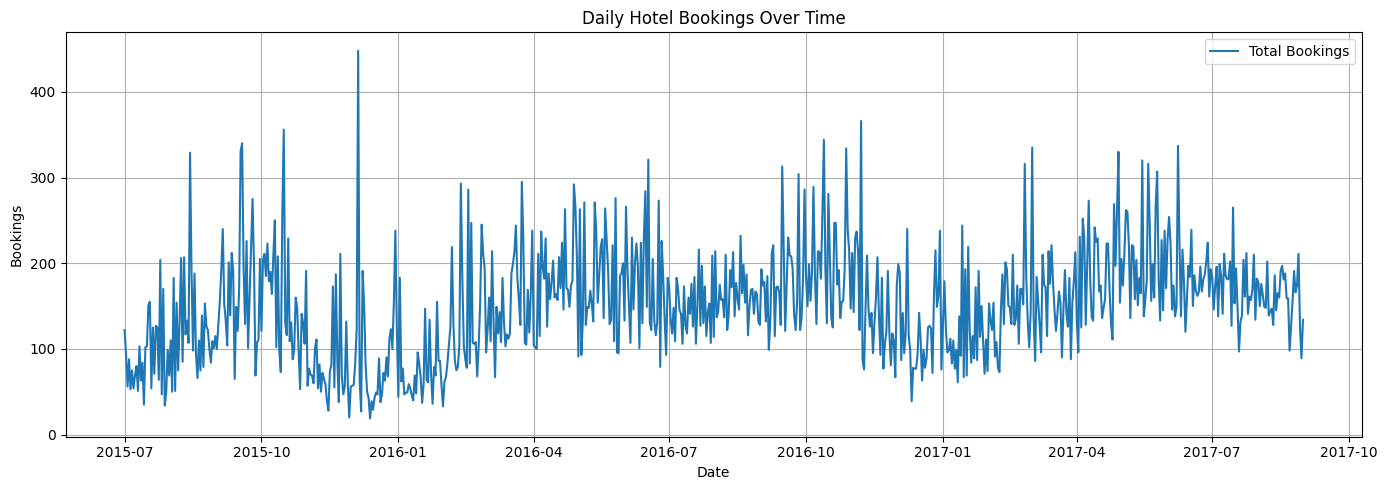

In [ ]:
# Plot total bookings over time
plt.figure(figsize=(14, 5))
plt.plot(daily_bookings, label='Total Bookings')
plt.title("Daily Hotel Bookings Over Time")
plt.xlabel("Date")
plt.ylabel("Bookings")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

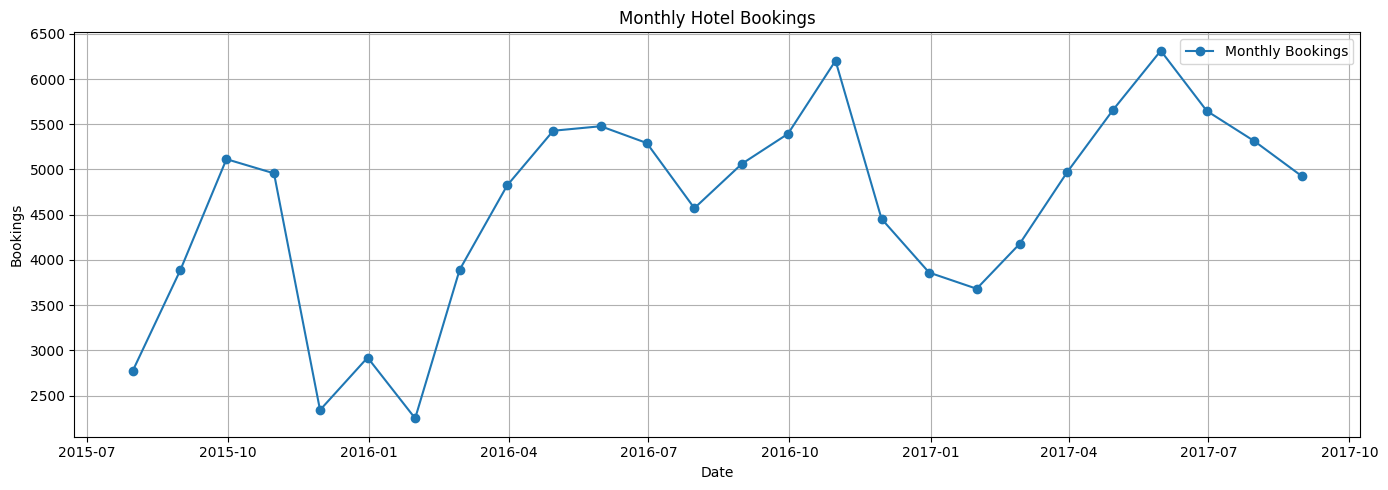

In [ ]:
# Resampled daily bookings to monthly
monthly_bookings = daily_bookings.resample('M').sum()

# Plot the monthly time series
plt.figure(figsize=(14, 5))
plt.plot(monthly_bookings, marker='o', label='Monthly Bookings')
plt.title("Monthly Hotel Bookings")
plt.xlabel("Date")
plt.ylabel("Bookings")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Identifying missing values, outliers, trends, and stationarity 

- In time series forecasting, missing dates can throw off models — so we make sure each month is present.

In [ ]:
# Checking for missing months
full_range = pd.date_range(start=monthly_bookings.index.min(),
                           end=monthly_bookings.index.max(),
                           freq='M')

# Reindex the series to the full date range
monthly_bookings = monthly_bookings.reindex(full_range)

# Renaming index
monthly_bookings.index.name = 'Month'

# Checking if any months are missing
print("Missing months (NaNs):")
print(monthly_bookings[monthly_bookings.isna().any(axis=1)])

Missing months (NaNs):
Empty DataFrame
Columns: [total_bookings]
Index: []


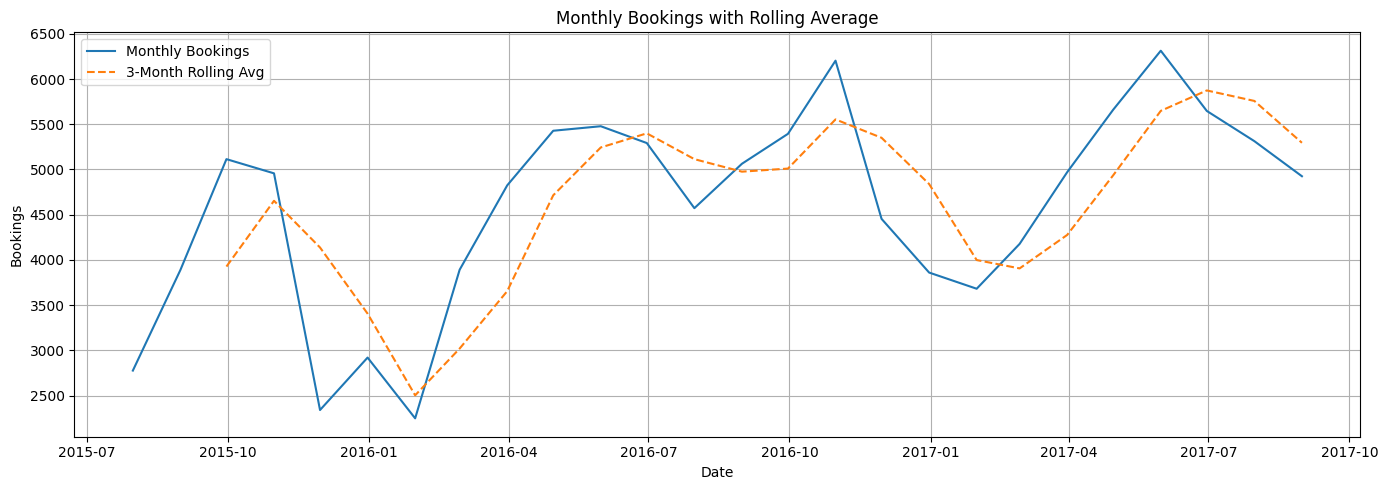

In [ ]:
# Adding 3-month rolling average
monthly_bookings['rolling_avg'] = monthly_bookings['total_bookings'].rolling(window=3).mean()

# Plot both original and smoothed line
plt.figure(figsize=(14, 5))
plt.plot(monthly_bookings['total_bookings'], label='Monthly Bookings')
plt.plot(monthly_bookings['rolling_avg'], label='3-Month Rolling Avg', linestyle='--')
plt.title("Monthly Bookings with Rolling Average")
plt.xlabel("Date")
plt.ylabel("Bookings")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Check for Stationarity (ADF Test)

In [ ]:
# Drop NaNs before testing
series = monthly_bookings['total_bookings'].dropna()

# Perform ADF test
result = adfuller(series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.6373969407979514
p-value: 0.08551174079306573
Critical Values:
   1%: -3.7529275211638033
   5%: -2.998499866852963
   10%: -2.6389669754253307


#### The series is not stationary.

## Differencing 

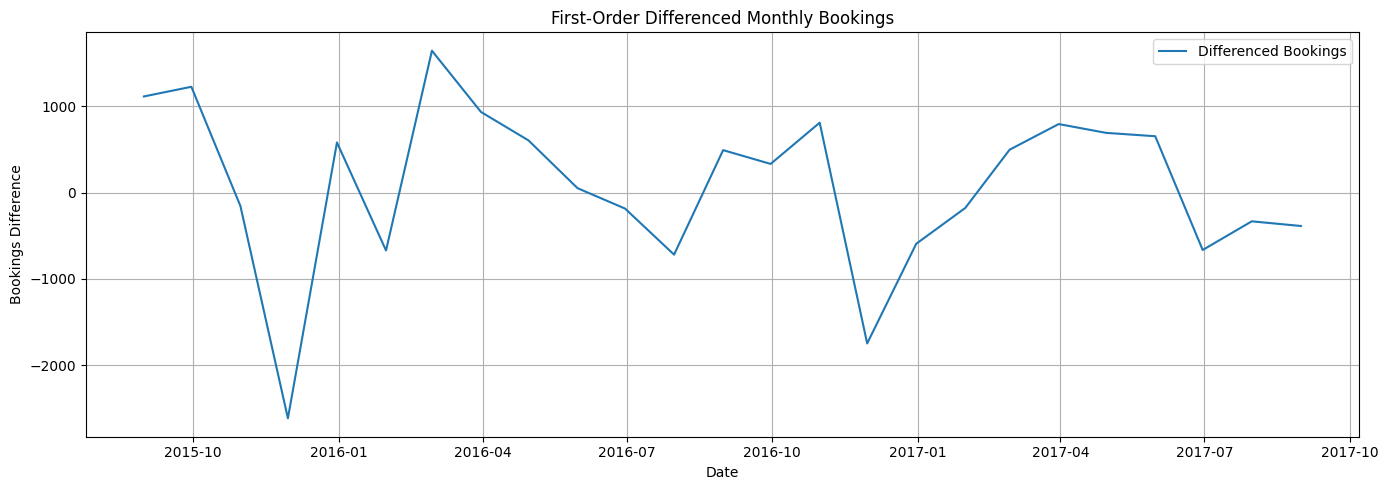

ADF Statistic (Differenced): -4.595979868892658
p-value (Differenced): 0.00013139151741173123
Critical Values:
   1%: -3.769732625845229
   5%: -3.005425537190083
   10%: -2.6425009917355373


In [41]:
# First-order differencing to remove trend
diff_series = series.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(14, 5))
plt.plot(diff_series, label='Differenced Bookings')
plt.title("First-Order Differenced Monthly Bookings")
plt.xlabel("Date")
plt.ylabel("Bookings Difference")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Re-run ADF test
from statsmodels.tsa.stattools import adfuller
result_diff = adfuller(diff_series)
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')

### Why we chose <b> Differencing </b> over Smoothing
- We used differencing to make the time series stationary, which is required for models like ARIMA. Unlike smoothing, which highlights trends, differencing removes them to stabilize the data for accurate forecasting.

### Visual Observations:
- <b> Summer Peaks: </b> Clear spikes in bookings between April and September, especially May–August each year. This is consistent with vacation travel during summer months.
- <b> Holiday Drop-offs: </b> Notably lower values in January and February, aligning with post-holiday and off-season trends.
- <b> Consistent Year-over-Year Pattern: </b> Indicates a seasonal cycle, likely driven by holidays, school breaks, and weather-related travel demand.

# Time Series Decomposition

## Additive Decomposition

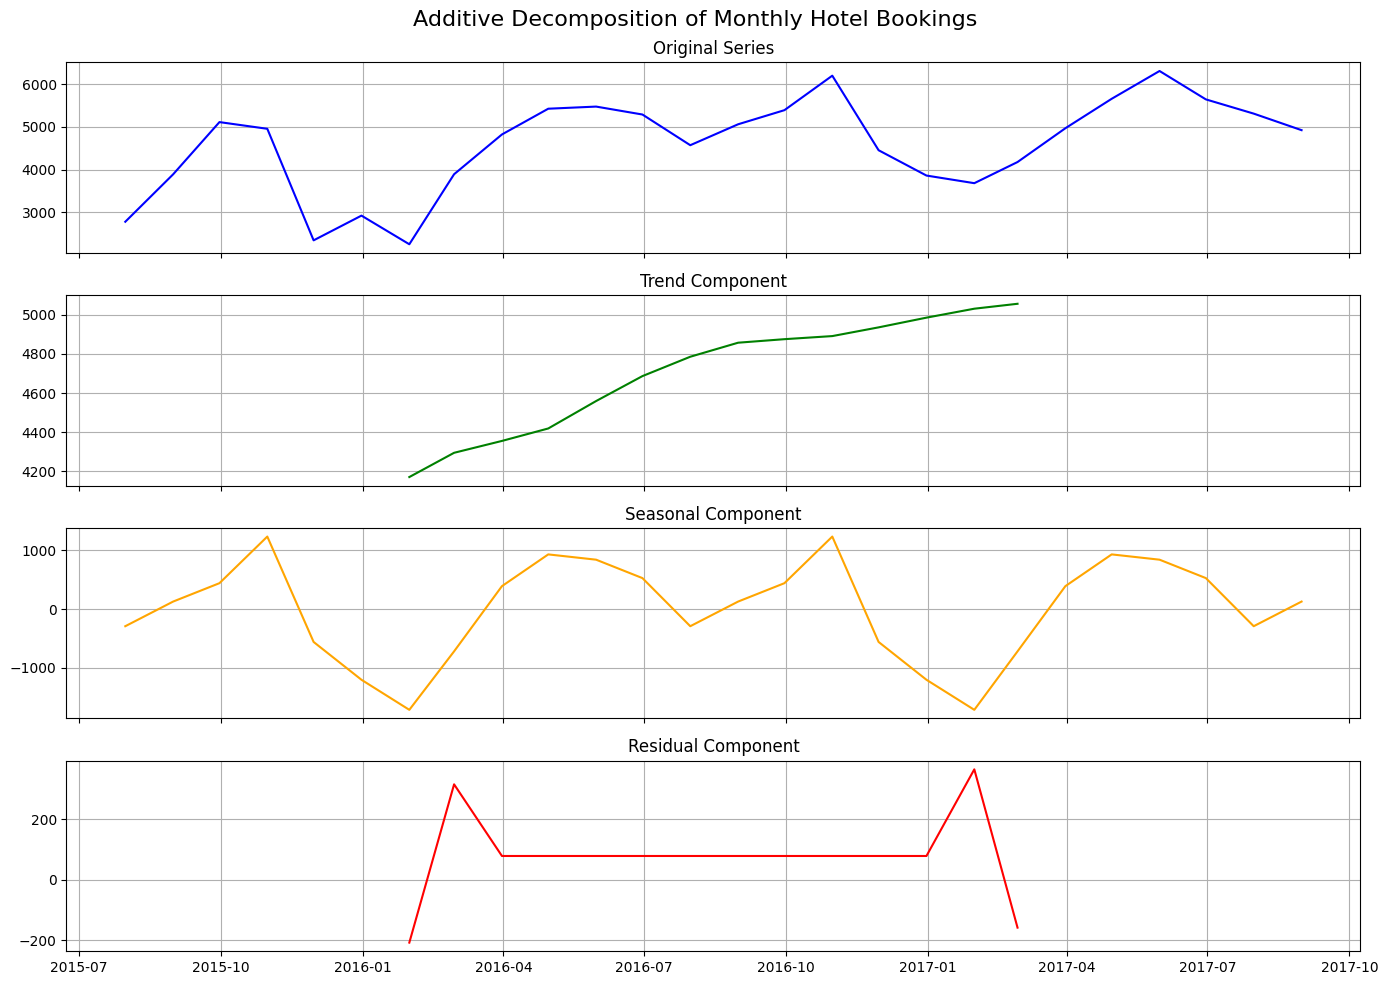

In [ ]:
# Ensuring monthly_bookings is correctly indexed with datetime and has no missing values
monthly_bookings = daily_bookings.resample('M').sum()
monthly_series = monthly_bookings['total_bookings'].dropna()

# Decomposing the original monthly bookings time series using additive model
decomposition = seasonal_decompose(series, model='additive', period=12)

# Plot each component separately with clear titles
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Original series
axs[0].plot(series, label='Original', color='blue')
axs[0].set_title('Original Series')
axs[0].grid(True)

# Trend
axs[1].plot(decomposition.trend, label='Trend', color='green')
axs[1].set_title('Trend Component')
axs[1].grid(True)

# Seasonality
axs[2].plot(decomposition.seasonal, label='Seasonality', color='orange')
axs[2].set_title('Seasonal Component')
axs[2].grid(True)

# Residuals
axs[3].plot(decomposition.resid, label='Residuals', color='red')
axs[3].set_title('Residual Component')
axs[3].grid(True)

plt.suptitle('Additive Decomposition of Monthly Hotel Bookings', fontsize=16)
plt.tight_layout()
plt.show()

## Multiplicative Decomposition

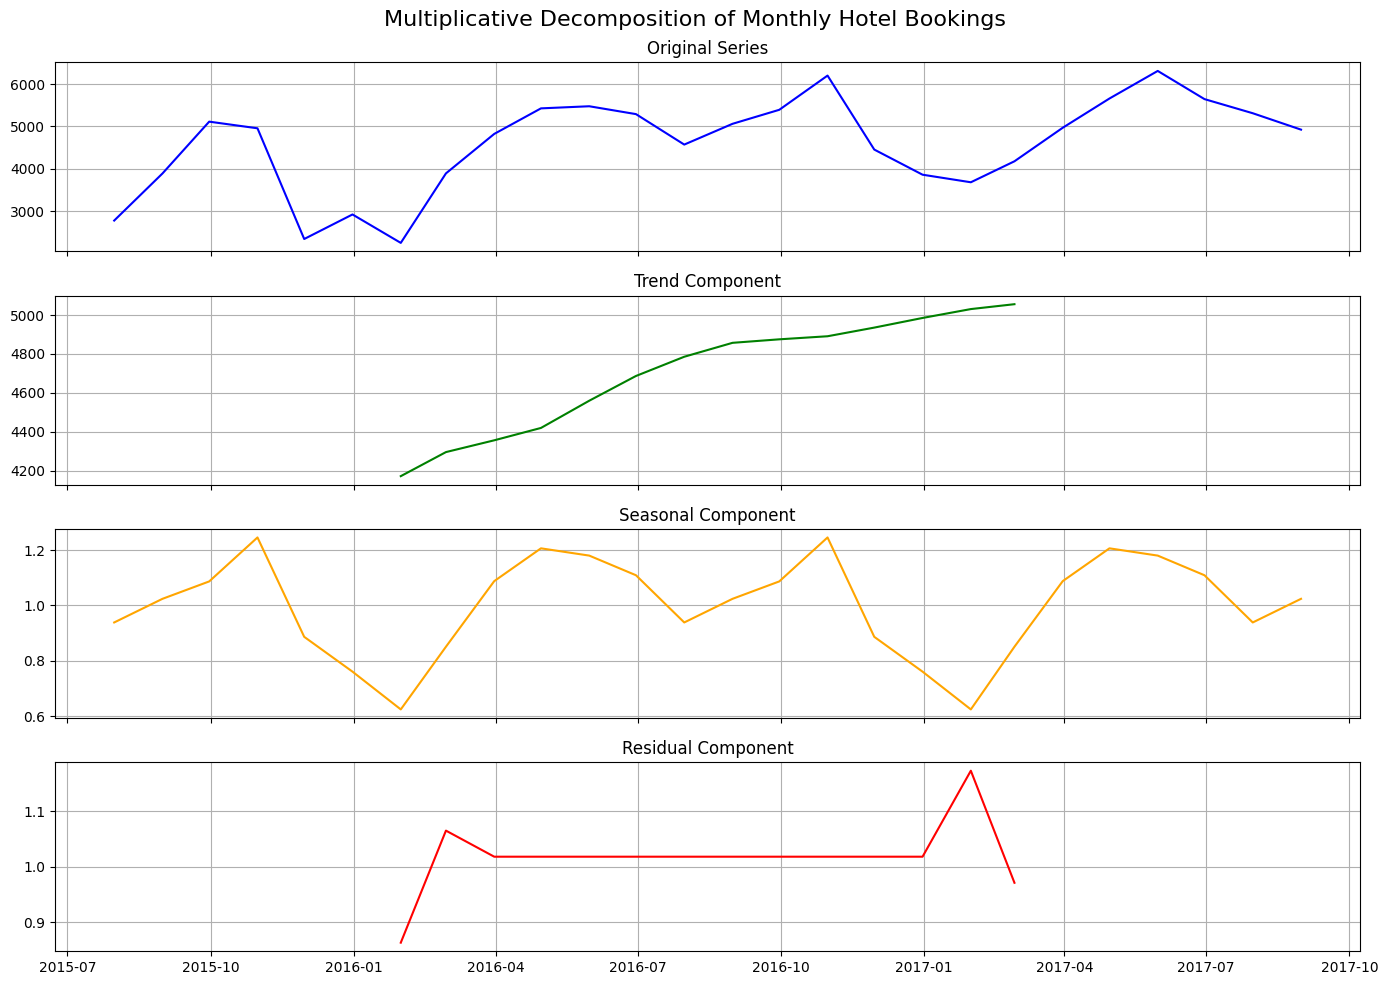

In [ ]:
# Decomposing the original monthly bookings time series using multiplicative model
multiplicative_decomposition = seasonal_decompose(series, model='multiplicative', period=12)

# Plot each component separately with clear titles
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Original series
axs[0].plot(series, label='Original', color='blue')
axs[0].set_title('Original Series')
axs[0].grid(True)

# Trend
axs[1].plot(multiplicative_decomposition.trend, label='Trend', color='green')
axs[1].set_title('Trend Component')
axs[1].grid(True)

# Seasonality
axs[2].plot(multiplicative_decomposition.seasonal, label='Seasonality', color='orange')
axs[2].set_title('Seasonal Component')
axs[2].grid(True)

# Residuals
axs[3].plot(multiplicative_decomposition.resid, label='Residuals', color='red')
axs[3].set_title('Residual Component')
axs[3].grid(True)

plt.suptitle('Multiplicative Decomposition of Monthly Hotel Bookings', fontsize=16)
plt.tight_layout()
plt.show()

### Additive vs Multiplicative
- For our dataset, <b> multiplicative decomposition is more appropriate </b> because of the seasonal patterns scale with the overall trend. As total bookings increase over time, the seasonal peaks and dips also grow proportionally. This behavior aligns better with real-world hotel demand, where high-season surges are more pronounced in high-traffic years. 
- Unlike the additive model, which assumes constant seasonal effects, the multiplicative model captures this dynamic more realistically, making it a better choice for analysis and forecasting.

### What insights can businesses gain from these components? 
- By analyzing the trend, seasonality, and residual components of the time series, businesses can gain valuable operational insights. 
    - The <b> trend </b> shows a steady increase in bookings, indicating long-term growth and rising demand for hotel services. 
    - The <b> seasonal </b> component reveals predictable demand cycles, with consistent peaks during summer months (April to August), helping hotels plan for staffing, pricing, and marketing. 
    - The <b> residuals </b> highlight unexpected variations, such as sudden drops or spikes, which may signal external disruptions or operational inefficiencies.
- Together, these components <b> support better forecasting </b>, resource allocation, and strategic decision-making.

In [ ]:
# Prepare the series
monthly = monthly_bookings['total_bookings'].asfreq('M').fillna(method='ffill')

# Split 80/20
split_index = int(len(monthly) * 0.8)
train, test = monthly[:split_index], monthly[split_index:]
forecast_index = test.index

# Evaluation function
def evaluate_model(true, pred):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'MSE': mse}

# 1. ARIMA
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()
arima_pred = arima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
arima_pred.index = forecast_index
arima_metrics = evaluate_model(test, arima_pred)

# 2. ETS (6-month seasonality)
ets_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=6,  # lowered from 12 to avoid the cycle error
    initialization_method='estimated'
)
ets_fit = ets_model.fit()
ets_pred = ets_fit.forecast(len(test))
ets_pred.index = forecast_index
ets_metrics = evaluate_model(test, ets_pred)


# 3. Prophet
prophet_df = monthly.reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet requires exact names

# Split
prophet_train = prophet_df.iloc[:split_index]

# Train and forecast
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Forecast
future = prophet_model.make_future_dataframe(periods=len(test), freq='M')
forecast = prophet_model.predict(future)

# Align predictions
prophet_pred = forecast.set_index('ds').loc[forecast_index]['yhat']
prophet_metrics = evaluate_model(test, prophet_pred)


# 4. LSTM
# Normalize data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(monthly.values.reshape(-1, 1))

# Prepare supervised data
def create_lagged_dataset(data, lag=12):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

lag = 12
X, y = create_lagged_dataset(scaled, lag)
train_X, test_X = X[:split_index-lag], X[split_index-lag:]
train_y, test_y = y[:split_index-lag], y[split_index-lag:]

# Reshape for LSTM
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

# Build and train model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(lag, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(train_X, train_y, epochs=100, verbose=0)

# Predict and inverse scale
lstm_pred = lstm_model.predict(test_X)
lstm_pred = scaler.inverse_transform(lstm_pred)
actual = scaler.inverse_transform(test_y.reshape(-1, 1)).flatten()
lstm_metrics = evaluate_model(actual, lstm_pred.flatten())

# Results
forecast_comparison = pd.DataFrame({
    'ARIMA': arima_metrics,
    'ETS': ets_metrics,
    'Prophet': prophet_metrics,
    'LSTM': lstm_metrics
}).T

# === Final Evaluation Table ===

def format_forecast_results(df):
    formatted = df.copy()
    formatted['MAPE (%)'] = formatted['MAPE'].apply(lambda x: f"{x:.2f}%")
    formatted['Avg Error (RMSE)'] = formatted['RMSE'].apply(lambda x: f"{x:.0f} bookings")
    formatted['MAE'] = formatted['MAE'].apply(lambda x: f"{x:.0f}")
    formatted['MSE'] = formatted['MSE'].apply(lambda x: f"{x/1_000_000:.2f}M")
    return formatted[['MAPE (%)', 'Avg Error (RMSE)', 'MAE', 'MSE']]

# Apply and print the final table
final_summary_table = format_forecast_results(forecast_comparison)
print("\n Forecast Model Comparison (80/20 Split):")
print(final_summary_table)

09:28:11 - cmdstanpy - INFO - Chain [1] start processing
09:28:11 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

 Forecast Model Comparison (80/20 Split):
        MAPE (%) Avg Error (RMSE)   MAE    MSE
ARIMA     24.85%    1476 bookings  1390  2.18M
ETS       19.73%    1437 bookings  1123  2.06M
Prophet    7.73%     585 bookings   446  0.34M
LSTM      22.92%    1389 bookings  1286  1.93M


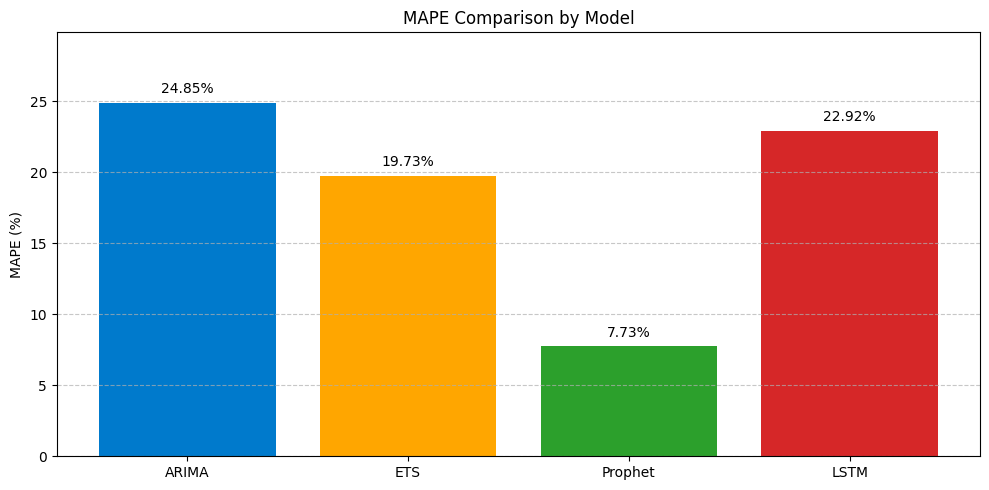

In [ ]:
# Extract data from final_summary_table
model_names = final_summary_table.index.tolist()
mape_values = [float(x.strip('%')) for x in final_summary_table['MAPE (%)']]
rmse_values = [int(x.split()[0]) for x in final_summary_table['Avg Error (RMSE)']]

# Plot MAPE comparison
plt.figure(figsize=(10, 5))
bars = plt.bar(model_names, mape_values, color=['#007acc', '#ffa600', '#2ca02c', '#d62728'])
plt.title('MAPE Comparison by Model')
plt.ylabel('MAPE (%)')
plt.ylim(0, max(mape_values) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)


for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords='offset points',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Summary 
- Among the four models evaluated, Prophet outperformed all others with the lowest error rates across all metrics, particularly in capturing seasonal patterns and trends. 
- ETS and LSTM performed moderately well, suitable for short-term forecasting, while ARIMA lagged behind due to its limited seasonality handling. 
- Based on these results, Prophet is the most accurate and robust model for forecasting hotel booking trends.

#### Which Model Works Best for Short-Term vs. Long-Term Forecasting?
- For <b> short-term forecasting</b>, <b> ETS and LSTM </b> are the most suitable models. 
    - ETS works well when demand patterns follow consistent, seasonal cycles, making it ideal for month-to-month planning or staffing decisions. 
    - LSTM also performs well in the short term, especially when modeling complex, nonlinear relationships.

- For <b> long-term forecasting</b>, <b> Prophet </b> is the best option. 
    - It automatically captures trend changes, seasonal effects, and special calendar events. 
    
In this project, <b> Prophet </b> achieved the lowest forecast error, making it the most reliable for strategic, high-level planning.

#### How Model Choice Changes by Industry
- In <b> hospitality and tourism </b>, models like Prophet and ETS are preferred. 
    - These industries often exhibit strong seasonality, and both models handle it well. 
    - Prophet is better for long-term demand trends, while ETS is effective for short-term operations.

- In <b> finance </b>, LSTM is often more appropriate due to the market’s nonlinear and volatile nature. 
    - ARIMA can still be used in more stable, trend-based financial forecasting.

- For <b> healthcare </b>, both ETS and Prophet work well. 
    - Healthcare data often follows recurring patterns (e.g., seasonal illnesses), and these models can adapt to that with minimal tuning.

- In <b> retail or e-commerce </b>, a hybrid approach works best. 
    - Use Prophet to capture predictable demand spikes during holidays and promotions, and LSTM for real-time or event-driven forecasting.

In [46]:
# Save cleaned version to CSV
df.to_csv("cleaned_timeseries.csv", index=False)